## Importando as bibliotecas

In [1]:
from difflib import SequenceMatcher

In [2]:
import netpixi
from netpixi.integration.gt import Graph
from netpixi.integration.gt import *
import seaborn as sns
from regression.integration.gt import *

import cpnet

from graph_tool import spectral
from graph_tool import clustering

import itertools


<frozen importlib._bootstrap>:914: ImportWarning: VendorImporter.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: VendorImporter.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: VendorImporter.find_spec() not found; falling back to find_module()


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import regression as reg

from scipy import stats
from matplotlib import pyplot as plt

## Refatorando o banco de dados

In [4]:
def convert_k_to_int(linha):
    linha = str(linha).replace(",", "")
    if 'k' in linha:
        linha = linha.replace("k", "")
        linha = float(linha) * 1000
    else:
        linha = float(linha)
    return linha

In [5]:
data = pd.read_csv('Github_data.txt')

In [6]:
data['star'] = data['star'].apply(convert_k_to_int)
data['commits'] = data['commits'].apply(convert_k_to_int)

In [7]:
data

,Unnamed: 0.1,Unnamed: 0,topic,name,user,star,fork,watch,issue,pull_requests,...,topic_tag,discription_text,discription_url,commits,branches,packages,releases,contributers,License,url
0,0,0,Data-Science,keras,keras-team,47900.0,18.1k,2.1k,"2,940",87,...,"['deep-learning', 'tensorflow', 'neural-networ...",Deep Learning for humans,http://keras.io/,5342.0,6,0,0,49,View license,https://github.com/keras-team/keras
1,1,1,Data-Science,scikit-learn,scikit-learn,40300.0,19.6k,2.2k,"1,505",764,...,"['machine-learning', 'python', 'statistics', '...",scikit-learn: machine learning in Python,https://scikit-learn.org,25405.0,21,0,0,108,View license,https://github.com/scikit-learn/scikit-learn
2,2,2,Data-Science,PythonDataScienceHandbook,jakevdp,23100.0,9.9k,1.5k,65,67,...,"['scikit-learn', 'numpy', 'python', 'jupyter-n...",Python Data Science Handbook: full text in Jup...,http://jakevdp.github.io/PythonDataSc…,234.0,5,0,0,0,View license,https://github.com/jakevdp/PythonDataScienceHa...
3,3,3,Data-Science,Probabilistic-Programming-and-Bayesian-Methods...,CamDavidsonPilon,21000.0,6.6k,1.4k,127,38,...,"['bayesian-methods', 'pymc', 'mathematical-ana...","aka ""Bayesian Methods for Hackers"": An introdu...",http://camdavidsonpilon.github.io/Pro…,1079.0,3,0,0,0,MIT,https://github.com/CamDavidsonPilon/Probabilis...
4,4,4,Data-Science,Data-Science--Cheat-Sheet,abhat222,18400.0,8.2k,1.5k,7,0,...,[],Cheat Sheets,NaN,363.0,3,0,0,0,Fetching contributors,https://github.com/abhat222/Data-Science--Chea...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,295,95,sensor,react-native-sensor-manager,kprimice,199.0,53,7,19,5,...,[],Native sensors access for react-native,NaN,45.0,1,0,0,0,Fetching contributors,https://github.com/kprimice/react-native-senso...
1496,296,96,sensor,weatherstation,androidthings,199.0,72,31,4,0,...,"['android-things', 'google-cloud-pubsub']",Sensor-based peripheral sample using Android T...,NaN,64.0,2,0,0,0,Apache-2.0,https://github.com/androidthings/weatherstation
1497,297,97,sensor,OctoPrint-Enclosure,vitormhenrique,198.0,77,32,63,2,...,"['temperature-sensor', 'enclosure', 'raspberry...",OctoPrint Enclosure Plugin,NaN,415.0,3,0,0,38,GPL-3.0,https://github.com/vitormhenrique/OctoPrint-En...
1498,298,98,sensor,SensorDashboard,pocmo,197.0,110,25,0,0,...,[],A sensor dashboard for Android plotting all se...,NaN,103.0,2,0,0,0,Apache-2.0,https://github.com/pocmo/SensorDashboard


In [26]:
nomes = []
nomes_repitidos = {}

for i, name in enumerate(data['name']):
    name = name.lower()
    if name not in nomes:
        nomes.append(name)
        nomes_repitidos[name] = 1
    else:
        nomes_repitidos[name] = nomes_repitidos[name] + 1
        nomes.append(f"{name}_{nomes_repitidos[name]}")
        data.at[i, 'name'] = f"{name}_{nomes_repitidos[name]}"

In [29]:
data.to_csv('Github_data_refatorado.csv', index=False)

## Criando o grafo

In [31]:
g = Graph(directed=False) # não-dirigido

t = {}

with open('Github_data_refatorado.csv', "r") as arquivo:
    arquivo.readline()
    for linha in arquivo:
        try:
            div = linha.split(',')
            top_tag = linha.split('[')[1].split(']')[0].replace("'", "").replace(" ", "").split(",")
            topic = div[2].lower()
            repositorio = div[3]
            
            if not g.has_vertex(repositorio):
                g.add_vertex(repositorio)
                if top_tag != ['']:
                    t[repositorio] = top_tag
                else:
                    t[repositorio] = [topic]
        except:
            continue

In [32]:
Lista = list(set(item for sublista in t.values() for item in sublista))
print(len(Lista))

3291


In [33]:
def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

def conta_similaridade(lista, lista2):
    cache = {}
    cont = 0
    for i, b in itertools.product(lista, lista2):
        if (i, b) in cache:
            cont += cache[(i, b)]
        else:
            sim = similar(i, b)
            if sim >= 0.95:
                cont += 1
            cache[(i, b)] = sim >= 0.95
    return cont

In [40]:
quant = len(t.values())

lista_numeros = []
cont = 0
for p, b in t.items():
    print(f"{cont}/{quant-1}", end = "\r")
    for i in t:
        nummero = conta_similaridade(t[i], b)
        lista_numeros.append(nummero)
        if p != i and not g.has_edge(p, i) and nummero >= 2:
            g.add_edge(p, i)
    cont += 1

In [41]:
lista_distinct = list(set(lista_numeros))[1:]
lista_count = []
for i in lista_distinct:
    (lista_numeros.count(i))
    lista_count.append(lista_numeros.count(i))

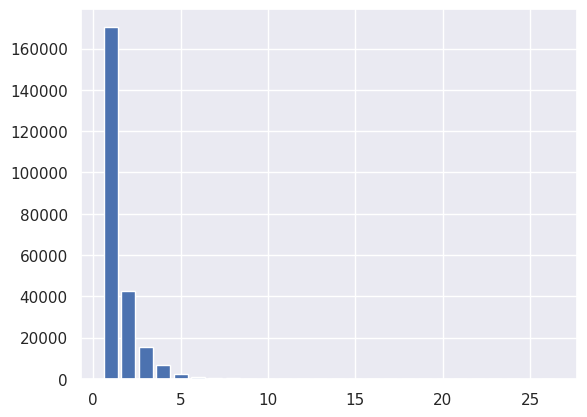

In [42]:
import matplotlib.pyplot as plt
import numpy as np

plt.bar(lista_distinct, lista_count)
plt.show()

## Salvando o grafo

In [70]:
gt_save(g, 'git_hub.net.gz')

## Compilando e renderizando o grafo

In [71]:
g = gt_load('git_hub.net.gz')
r = netpixi.render('git_hub.net.gz')

## Melhorando visualmento o grafo

In [45]:
# mudar a cor de fundo do grafo
r.graph(color=0xffffff)

# mudar a cor e o tamanho dos vértices
r.vertex_default(color=0x000000, size=10)

# mudar um vértice específico a partir de seu id
r.vertex(0, color=0xff0000, size=20)
r.vertex(1, color=0xff0000, size=20)

# mudar a cor, a espessura e a curvatura das arestas
r.edge_default(color=0x000000, width=1, curve1=1, curve2=1)

## Análise exploratória do grafo

In [58]:
# Números de vértices

n = g.num_vertices()
n

987

In [59]:
# Número de arestas

m = g.num_edges()
m

34179

In [60]:
# Número máximo possível de arestas

if g.is_directed():
    max_edges = n * (n - 1)
else:
    max_edges = n * (n - 1) // 2
max_edges

486591

In [61]:
# Densidade

d = m / max_edges
d

0.07024174306553142

In [66]:
# Propriedades de cada vértice

data = gt_data(g)

# Degree

degrees = []
for v in g.all_vertices():
    degrees.append(v.total_degree())
    
data['degree'] = degrees
data

,degree
id,
0,240
1,139
2,33
3,28
4,5
...,...
982,1
983,1
984,2


count    987.000000
mean      69.258359
std       81.032930
min        1.000000
25%        9.000000
50%       37.000000
75%      103.000000
max      362.000000
Name: degree, dtype: float64

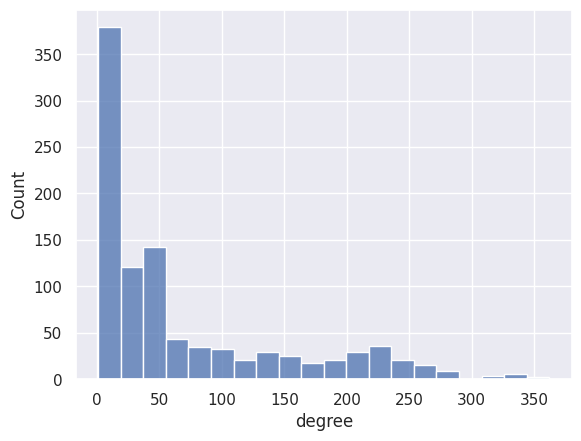

In [67]:
# Histograma do degree

sns.histplot(data['degree']);
data['degree'].describe()

## Limpando o grafo

In [55]:
g = gt_clean(g)
m = gt_draw.sfdp_layout(g)
gt_move(g, m)
gt_save(g, 'git_hub.net.gz')
netpixi.render('git_hub.net.gz', infinite=True);

In [56]:
gt_clean(g)
m = gt_draw.fruchterman_reingold_layout(g)
gt_move(g, m)
gt_save(g, 'git_hub.net.gz')
netpixi.render('git_hub.net.gz');

# Análise das variáveis dependentes e independentes

In [ ]:
data

In [ ]:
lc = clustering.local_clustering(g)

clustering = []
for value in lc:
    clustering.append(value)

In [ ]:
g1 = gt_load('git_hub.net.gz')
gt_data(g1)

In [ ]:
for i in g:
    print(i["props"])

In [ ]:
result = reg.linear(data=data, formula='commits ~  + star')
result.micro_summary()